In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
sess = None

def reset_vars():
    sess.run(tf.global_variables_initializer())

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

<!-- requirement: images/matrix.svg -->
<!-- requirement: small_data/housing.pkl -->

# Machine Learning in TensorFlow

At this point, we have covered enough TensorFlow to be able to start using it to build machine learning models.  Before we get to that, let's review some basic concepts of machine learning.

All of the examples we will discuss in this course will be examples of **supervised machine learning**.  In supervised machine learning, we deal with two data structures, a **feature matrix** $X_{ji}$ and a **label vector** $y_j$.  Each column $i$ of the feature matrix represents one particular feature.  (Each feature must be a numeric value.  The process of converting non-numeric data into numeric data is called **vectorization**, but we will not cover it in detail.)  Each row $j$ of the feature matrix represents a particular **observation**.  Each observation has a single value for each feature, recorded as $X_{ji}$.  Each observation also has an associated label $y_j$.

![feature matrix](images/matrix.svg)

The goal of supervised machine learning is to build a function $f$ that can estimate the value of the label from the associated row of the feature matrix.  That is, we wish to have

$$ f(X_{j\cdot}) \approx y_j $$

Once we have such a function, we can predict the label for a new observation $\tilde x$ with $f(\tilde x)$.

Supervised machine learning is further divided by the type of label.  **Regression** is the case when the label can vary continuously.  In this case, the distance between the actual and predicted label is meaningful.  Prediction of a house price is an example of regression.  If the label just indicates a class, the problem is **classification**.  There is no inherent ordering of the classes; the difference of the actual and predicted labels is not meaningful, except in the sense of whether it is non-zero.  Predicting whether a home will sell or not would be a classfication problem.

## Linear models

A particular regression algorithm is defined by two things: the functional form of $f$ and the error metric being minimized.  We'll start by discussing the former.

A linear model is one that is linear in each of the features.  That is, we can write

$$ f(X_{j\cdot}) = \sum_i X_{ji} W_i + b $$

where $W_i$ is a vector of weights, one for each feature, and $b$ is a bias term.  In the fitting process, we choose values for these parameters to optimize the model.

For concrete example, we'll load in some census data about housing prices in the Boston area.

In [4]:
import dill
from sklearn.model_selection import ShuffleSplit

with open("small_data/housing.pkl", "r") as fin:
    housing = dill.load(fin)

For reasons we will discuss later, it's a good idea to separate the data into a training set and a testing set.  This code puts 80% of the data in the training set and reserves 20% for testing.

In [5]:
for train, test in ShuffleSplit(1, 0.2, random_state=42).split(housing.data):
    X_train = housing.data[train]
    y_train = housing.target[train]
    X_test = housing.data[test]
    y_test = housing.target[test]

print X_train.shape

(404, 13)


We have 13 different features.  (We're not going to worry about what they represent right now.  The training data are 404 different observations.  This is a rather small number, compared to what we'll see later, but it suits us for right now.

We're also going to shift and scale the data, so that all columns are centered about zero and have a standard deviation of 1.  The reasoning for this will be discussed later.

In [6]:
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

Xs_train = (X_train - X_mean) / X_std
Xs_test = (X_test - X_mean) / X_std

print "Mean:", Xs_test.mean()
print "Std: ", Xs_test.std()

Mean: 0.0305379344872
Std:  0.973384504202


Let's start by considering just a single feature.  In this case, there is a single weight, and the model is simply

$$ f(X_j) = X_j W + b $$

Take a minute to adjust the weight and bias parameters below to generate a fit that looks good.

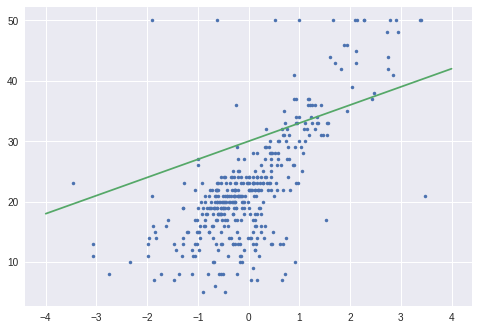

In [7]:
W = 3   # Weight
b = 30  # Bias

plt.plot(Xs_train[:,5], y_train, '.')
xx = np.linspace(-4, 4)
plt.plot(xx, xx * W + b)

## Error metrics

We can actually do quite well fitting a line by eye, at least in the case of a single feature.  But we would rather let the computer do the fitting for us, and to do this, we need a measure of how good a fit is.  This is the task of an **error metric**.

There are a number of different metrics for regression, but we will consider only the **mean squared error** (MSE).  For each observation $j$, the error is just the difference between the actual, or **ground truth**, label and the prediction: $f(X_{j\cdot}) - y_j$.  We generally don't care about the sign of the error (being high or low is equally bad), so we'll take the square of this value and average that over all the observations.

$$ MSE = \frac1n \sum_{j=1}^{n} \left[ f(X_{j\cdot}) - y_j \right]^2 $$

If we add this calculation, we no longer have to rely on our eyes to tell us the quality of the fit.

Training Error: 104.425567965
Testing Error:  107.232832058


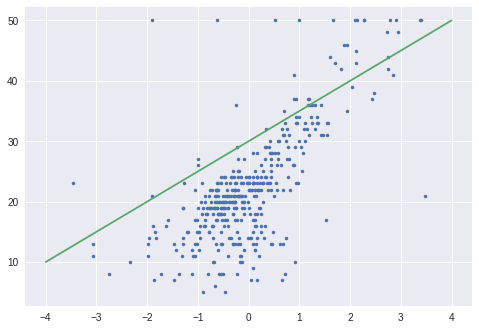

In [8]:
W = 5   # Weight
b = 30  # Bias

plt.plot(Xs_train[:,5], y_train, '.')
plt.plot(xx, xx * W + b)

print "Training Error:", ((Xs_train[:,5] * W + b - y_train)**2).mean()
print "Testing Error: ", ((Xs_test[:,5] * W + b - y_test)**2).mean()

Note that we look at both the error on the training data and the testing data.  Since the goal of our model is to make accurate predictions about new data, not used in training, the testing error is a more honest representation of the performance of our model.

In this case, you'll find that the training and testing error are nearly the same.  As our models become more complicated, we'll see that there's a danger in **overfitting**: The model becomes so flexible that it can fit non-generic noise in the training set.  This shows up as an increasing gap between the training and testing errors. We'll discuss strategies to deal with overfitting later.

## Gradient descent

Now that we have a model and metric to measure it's performance, we need an algorithm to choose the best parameters for that model.  This is another place where there are several choices; we'll discuss the **gradient descent** algorithm.

As an introductory example, let's consider the case where we are optimizing just a single weight parameter $W$.  Then we can write the total error, or **loss** as a function of that: $L(W)$.  We want to find $W^*$ such that $L(W^*)$ is a minimum, or equivalently, so $dL(W^*)/dW = 0$.  Using the same trick from the last notebook, we can use Newton's method on the derivative to find the minimum:

$$ W^* = W - \left. \frac{dL}{dW} \middle/ \frac{d^2 L}{dW^2} \right. $$

For gradient descent, we'll assume that we can calculate (or at least approximate) the first derivative, but not the second derivative.  (In the multi-dimensional case, the first derivative becomes the gradient vector and the second derivative becomes the **hessian** matrix, which requires a bit more work to compute.)  Instead, we make use only of the knowledge that near a minimum the second derivative will be positive.  Thus, in gradient descent, the parameters are updated according to

$$ W^* = W - \eta \frac{dL}{dW} $$

where $\eta$ is a constant called the **learning rate**.

The learning rate is an example of a **hyperparameter**.  This is a number that enters the model, but is not set during the fitting process.  You will need to choose hyperparameters before running the model, and you may need to spend some adjusting them to get the model behaving properly.  (That said, for linear regression, we can estimate the hessian of the loss to be the covariance of the feature columns.  This is why we normalized them at the beginning.)

> **Aside:** Gradient descent is not the only way to fit a linear model.  Linear regression actually admits an exact solution to the model $f(X_{j\cdot}) = X_{j\cdot} \cdot W$, namely

> $$ \hat W = \left( X^T X \right)^{-1} X^T y $$

> For this particular example, linear regression would work just fine.  However, these matrix operations become increasing expensive as the size of the feature matrix grows.  When there are many observations, gradient descent will generally be faster.

Let's set up the one-feature gradient descent in TensorFlow.  Both the weight and the bias will be variables, so that they can be updated each step.  (We have defined them to be tensors, in anticipation of a later multi-dimensional model.)  Since we don't know where to start them, we'll initialize them to be zero.

In [9]:
reset_tf()

W = tf.Variable([[0.0]], name="weight")
b = tf.Variable([0.0], name="bias")

Each time we need to calculate something from the data, we'll feed the data in to these placeholders.  (We'll see why in a little bit.)  We use `None` in the shape to indicate that we can feed in any number of observations.

In [10]:
x = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='x')
y_label = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='y_label')

Now we can calculate the predicted labels and the loss.

In [11]:
y = tf.matmul(x, W) + b
loss = tf.reduce_mean(tf.square(y - y_label))

And finally we can set up the gradient descent step.

In [12]:
eta = tf.constant(0.1, name="learning_rate")
iterate_W = W.assign(W - eta * tf.gradients(loss, W)[0])
iterate_b = b.assign(b - eta * tf.gradients(loss, b)[0])

And let's go!

In [15]:
reset_vars()

for i in xrange(20):
    sess.run([iterate_W, iterate_b], feed_dict={x: Xs_train[:, 5:6],
                                                y_label: y_train.reshape(-1, 1)})
    print sess.run(loss, feed_dict={x: Xs_train[:, 5:6],
                                    y_label: y_train.reshape(-1, 1)})

392.322
266.777
186.428
135.005
102.094
81.0313
67.5511
58.9237
53.4022
49.8684
47.6068
46.1594
45.233
44.6401
44.2607
44.0179
43.8625
43.763
43.6993
43.6586


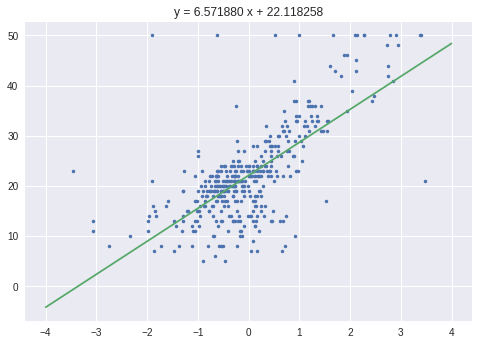

In [16]:
W_val = sess.run(W)[0,0]
b_val = sess.run(b)[0]

plt.plot(Xs_train[:,5], y_train, '.')
plt.plot(xx, xx * W_val + b_val)
plt.title('y = %f x + %f' % (W_val, b_val));

We picked the learning rate more or less at random.  Let's see what happens with different learning rates.

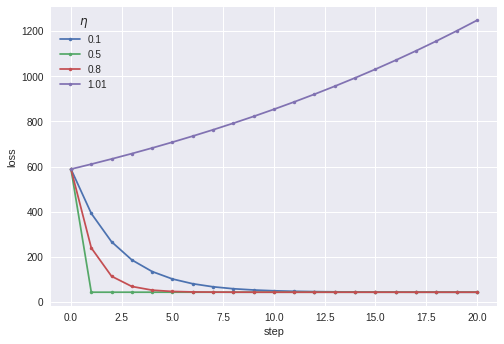

In [17]:
etas = [0.1, 0.5, 0.8, 1.01]
errors = []
Ws = []

for e in etas:
    reset_vars()
    errors.append([sess.run(loss, feed_dict={x: Xs_train[:, 5:6],
                                                y_label: y_train.reshape(-1, 1)})])
    Ws.append([sess.run(W)[0,0]])
    for i in xrange(20):
        sess.run([iterate_W, iterate_b], feed_dict={x: Xs_train[:, 5:6],
                                                    y_label: y_train.reshape(-1, 1),
                                                    eta: e})
        errors[-1].append(sess.run(loss, feed_dict={x: Xs_train[:, 5:6],
                                                    y_label: y_train.reshape(-1, 1)}))
        Ws[-1].append(sess.run(W)[0,0])

plt.plot(np.array(errors).T, '.-')
plt.legend(etas, loc=2, title=r'$\eta$')
plt.xlabel('step')
plt.ylabel('loss');

In this case, the optimal learning rate is 0.5.  We find the optimal parameters right away.  $\eta = 0.1$ takes a bit longer to work towards these parameters.  Learning rates larger than the optimal rate also take a bit longer to converge.  When $\eta$ is more than twice the optimal learning rate, the process no longer converges.

We can visualize what's going on by plotting the loss against the parameter $W$ for each of these.  We see that these points define a parabola.  When the learning rate is optimal, we go directly to the base of the parabola.  When it is too small, we move down the side the parabola towards the minimum.  When it is too large, we over-shoot the minimum and land on the other arm of the parabola.  If we don't overshoot too badly, we can still converge, but if we end up farther away than our starting position, the process diverges.

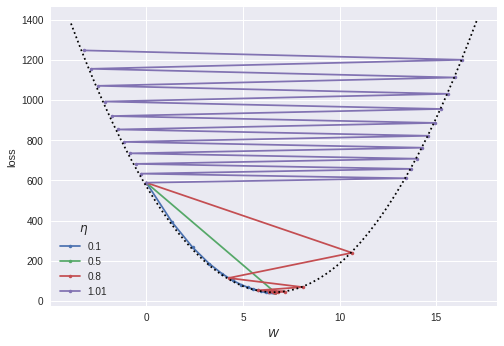

In [18]:
plt.plot(np.array(Ws).T, np.array(errors).T, '.-')
# This is just an eyeball estimate of the loss function
plt.plot(np.linspace(-3.9, 17.1),
         12.2 * (np.linspace(-3.9, 17.1) - 6.57)**2 + 43.2, 'k:')
plt.legend(etas, title=r'$\eta$')
plt.xlabel('$W$')
plt.ylabel('loss');

This case is particularly well-behaved, a result of the simple model and the small number of parameters.  (Using the training error rather than the testing error also smoothed things out.)  Things will not be so clear in real-world problems, but the general behavior is the same.

> The learning rate may be chosen by trial and error, but it is usually best to choose it by monitoring learning curves that plot the objective function as a function of time.  This is more of an art than a science, and most guidance on this subject should be regarded with some skepticism.

> &mdash;Ian Goodfellow, Yoshua Bengio, and Aaron Courville, [Deep Learning](http://www.deeplearningbook.org/)

If you get confused by the behavior of your learning curves, don't despair.  You are in [good company](http://lossfunctions.tumblr.com/).

## Stochastic gradient descent

We used the full training set in calculating the loss function above.  With only 404 observations, this is easy enough.  But when dealing with millions of observations (or more), this will become infeasible. It's also unnecessary.  Most observations in a large data set will have many neighbors that impart almost the same information.  We don't need all of them in our learning process.

If we take this reasoning to the extreme, we can train based on the error of a single observation at a time.  We want to train with the "most unexpected" datum each time.  In lieu of trying to figure this out, we'll feed the data randomly, so this process is known as **stochastic gradient descent**.  Each individual step will be noisy, since it contains only a small amount of information.  This means that you will need more steps and a smaller learning rate.

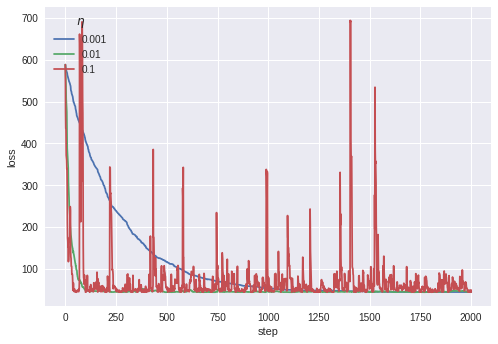

In [19]:
etas = [0.001, 0.01, 0.1]
errors = []

for e in etas:
    reset_vars()
    errors.append([sess.run(loss, feed_dict={x: Xs_train[:, 5:6],
                                                y_label: y_train.reshape(-1, 1)})])
    for i in xrange(2000):
        j = np.random.randint(len(y_train))
        sess.run([iterate_W, iterate_b], feed_dict={x: [[Xs_train[j,5]]],
                                                    y_label: [[y_train[j]]],
                                                    eta: e})
        errors[-1].append(sess.run(loss, feed_dict={x: Xs_train[:, 5:6],
                                                    y_label: y_train.reshape(-1, 1)}))

plt.plot(np.array(errors).T, '-')
plt.legend(etas, loc=2, title=r'$\eta$')
plt.xlabel('step')
plt.ylabel('loss');

In addition to generally being faster than batch processing, stochastic gradient descent is often more robust.  The noise inherent in this process is often enough to push us out of local minima of the loss function.  (A downside of this noise it that it makes it harder for the model to finally converge at the end.)  Additionally, stochastic gradient descent supports **online learning**.  We can update an existing model with new data just by running some descent steps on it.

## Minibatch processing

**Minibatch processing** attempts to combine the benefits of batch and stochastic gradient descent by training on a "minibatch", a subset of the whole data, at a time.  This increases the accuracy of the gradient calculation, reducing the noise in each step, while still avoiding much of the duplication in the whole set.  Minibatches can often be about as fast as individual steps&mdash;the parallelism available in modern CPUs and especially GPUs is wasted if we are calculating a single row at a time.

A batch size of 100 is usually enough to smooth out the noise.  In our case, the full data is not so much larger than the batch size, so there is little difference in performance.

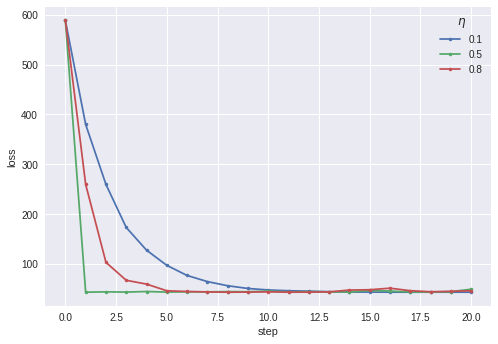

In [20]:
etas = [0.1, 0.5, 0.8]
errors = []
BATCH_SIZE = 100

for e in etas:
    reset_vars()
    errors.append([sess.run(loss, feed_dict={x: Xs_train[:, 5:6],
                                                y_label: y_train.reshape(-1, 1)})])
    for i in xrange(20):
        j = np.random.choice(len(y_train), BATCH_SIZE, replace=False)
        sess.run([iterate_W, iterate_b], feed_dict={x: Xs_train[j,5:6],
                                                    y_label: y_train[j].reshape(-1,1),
                                                    eta: e})
        errors[-1].append(sess.run(loss, feed_dict={x: Xs_train[:, 5:6],
                                                    y_label: y_train.reshape(-1, 1)}))

plt.plot(np.array(errors).T, '.-')
plt.legend(etas, title=r'$\eta$')
plt.xlabel('step')
plt.ylabel('loss');

## Built-in optimization

TensorFlow has a number of optimizers, including a gradient descent optimizer, built in.  Instead of working out the gradient descent step ourselves, we can tell it to optimize our loss function for us.  It will automatically calculate the gradient descent step for us.  The results are essentially identical:

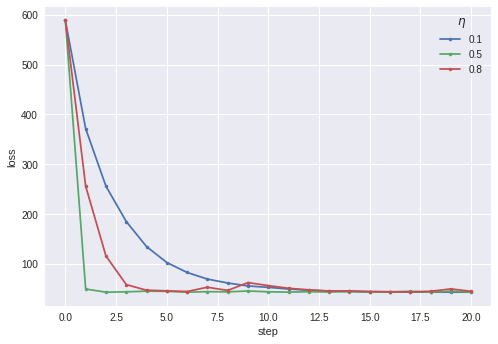

In [21]:
etas = [0.1, 0.5, 0.8]
errors = []
BATCH_SIZE = 100

for e in etas:
    reset_vars()
    optimizer = tf.train.GradientDescentOptimizer(e)  # learning rate
    train = optimizer.minimize(loss)
    errors.append([sess.run(loss, feed_dict={x: Xs_train[:, 5:6],
                                                y_label: y_train.reshape(-1, 1)})])
    for i in xrange(20):
        j = np.random.choice(len(y_train), BATCH_SIZE, replace=False)
        sess.run(train, feed_dict={x: Xs_train[j,5:6],
                                   y_label: y_train[j].reshape(-1,1)})
        errors[-1].append(sess.run(loss, feed_dict={x: Xs_train[:, 5:6],
                                                    y_label: y_train.reshape(-1, 1)}))

plt.plot(np.array(errors).T, '.-')
plt.legend(etas, title=r'$\eta$')
plt.xlabel('step')
plt.ylabel('loss');

How did the optimizer know which parameters to optimize?  By examining the computation graph, the optimizer can find all variables involved in the calculation.  All variables created with the keyword option `trainable=True`, the default, are considered to be parameters that need to be optimized.  The optimizer will calculate the gradient of the loss with respect to those parameters and update their values appropriately.

## Exercise: Multi-dimensional linear regression

Build a linear model incorporating all 13 features.  Tune the training rate appropriately.  By how much can you reduce the mean squared error?

In [ ]:
# key
etas = [0.05, 0.08, 0.1, 0.15]
errors = []
BATCH_SIZE = 100

W = tf.Variable(tf.zeros((13,1)), name="weight")
b = tf.Variable(tf.zeros(1), name="bias")
x = tf.placeholder(shape=[None, 13], dtype=tf.float32, name='x')
y_label = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='y_label')

y = tf.matmul(x, W) + b
loss = tf.reduce_mean(tf.square(y - y_label)) #MSE


for e in etas:
    reset_vars()
    optimizer = tf.train.GradientDescentOptimizer(e)  # learning rate
    train = optimizer.minimize(loss)
    errors.append([sess.run(loss, feed_dict={x: Xs_train, y_label: y_train.reshape(-1,1)})])
    for i in xrange(20):
        j = np.random.choice(len(y_train), BATCH_SIZE, replace=False)
        sess.run(train, feed_dict={x: Xs_train[j,:], y_label: y_train[j].reshape(-1,1)})
        errors[-1].append(sess.run(loss, feed_dict={x: Xs_train, y_label: y_train.reshape(-1,1)}))
        
plt.plot(np.array(errors).T, '.-')
plt.legend(etas, title=r'$\eta$')
plt.xlabel('step')
plt.ylabel('loss');

## Logistic Regression

Now we turn to the problem of classification.  Recall that the labels now represent classes.  We'll start with the case of two-class classification.  Each observation will either be a member of a target class (given label 1) or not (given label 0).  Here we'll classify census tracts on whether their average house price is above 20, in whatever units we happen to be using.

In [54]:
yc_train = np.float32(y_train > 20)
yc_test = np.float32(y_test > 20)

One approach to classification problems is to develop a function that returns the probability of an observation belong to the target class.  We can use this, along with a threshold probability, to actually predict the class.  (By default the threshold would be $\bar p = 0.5$, but this could be adjusted to reflect the relative importance of false positives and false negatives.)

We could use a linear model as a probability estimate.  But the linear model will give us numbers less than 0 and greater than 1, which are meaningless as probabilities.  The usual solution is to send the output of the linear model into the **logistic** (or **sigmoid**) function:

$$ f(x) = \frac{1}{1 + e^{-x}} $$

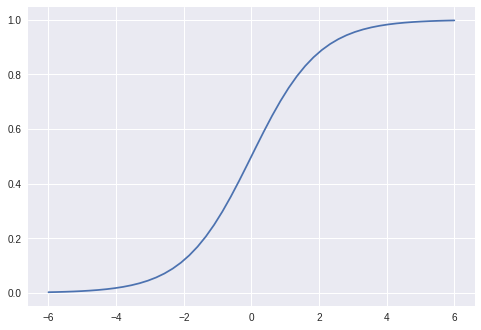

In [55]:
lx = np.linspace(-6,6)
plt.plot(lx, 1 / (1 + np.exp(-lx)));

This smoothly maps our linear model's output to the range [0, 1].

## Cross Entropy

We also need to consider how to evaluate the performance of a probabilistic model.  While we could use mean squared error, but that doesn't quite capture our intuition about probability.  Suppose we have an observation with label 0.  One model predicts a $p=0.9$ while a second predicts $p = 0.99$.  The former should happen one time in ten, while the latter only once in a hundred.  But the squared errors are comparable (0.81 vs 0.9801).

A metric that better captures this nature is the **cross entropy**, or **log-loss**:

$$ L = -\frac{1}{n}\sum_{j=1}^{n} y_j \log p_j + (1 - y_j) \log (1-p_j) $$

This is not as complicated as it may appear.  Because the labels $y_j \in \{0, 1\}$, only one term contributes from each summand.  If $y_j = 1$, the summand becomes simply $\log p_j$, the log of the probability we put on it being in class 1.  If $y_j = 0$, we get just $\log (1-p_j)$, which is the log of probability we put on it being in class 0.  As this probability approaches zero, the log becomes deeply negative, so the entropy becomes large.

> **Aside:** There is a deep connection between the cross-entropy metric and information theory.  In this case, the entropy is measuring the average number of bits per observation we'd need to specify the classes correctly, given an optimal encoding.

Although the formula for the entropy is more complicated than the mean squared error, TensorFlow can easily use the chain rule to calculate the necessary gradients.  It's even easier than you might think, because TensorFlow provides both the logistic function (as `tf.nn.sigmoid()`) and a entropy calculated from logistic values (as `tf.nn.sigmoid_cross_entropy_with_logits()`).

Most of the setup is the same as for linear regression, but we'll use the new loss function.

In [56]:
reset_tf()

W = tf.Variable(tf.zeros((13, 1)), name="weight")
b = tf.Variable(tf.zeros(1), name="bias")

x = tf.placeholder(shape=[None, 13], dtype=tf.float32, name='x')
y_label = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='y_label')

y = tf.matmul(x, W) + b
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=y, labels=y_label))

While the entropy is good for the purposes of a loss function, it is a bit hard to interpret.  A more human-readable metric is the **accuracy**, which measures what fraction of the labels we predicted correctly.

Here, we make a prediction by calling the logistic function on our linear model, and then comparing that to a threshold of 0.5.  The accuracy is measured by figuring if the predictions are equal to the ground truth labels, casting the result to a float, and taking the average.

In [57]:
predicted = tf.cast(tf.nn.sigmoid(y) > 0.5, np.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, y_label), np.float32))

In [58]:
train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

reset_vars()

for i in xrange(50):
    j = np.random.choice(len(y_train), BATCH_SIZE, replace=False)
    sess.run(train, feed_dict={x: Xs_train[j,:], 
                               y_label: yc_train[j].reshape(-1,1)})
    if i % 5 == 0:
        print sess.run([loss, accuracy], feed_dict={x: Xs_test, 
                                                    y_label: yc_test.reshape(-1, 1)})

[0.51280946, 0.78431374]
[0.41210249, 0.81372547]
[0.37221852, 0.82352942]
[0.35035011, 0.86274511]
[0.33357039, 0.872549]
[0.33241209, 0.872549]
[0.31969368, 0.86274511]
[0.31628716, 0.872549]
[0.30822617, 0.86274511]
[0.30553055, 0.86274511]


Our model is able to predict 88% of the test data correctly.  Note that in some steps, the entropy improves while the accuracy remains constant.  By measuring our confidence in an answer, the entropy allows improvements even when they don't change any prediction.

## Softmax classification

Multiclass classification involves more than two classes. While we could use multiple binary classifiers to solve this problem, there are models that naturally handle multiple classes.  The **softmax** function is one of these.

The softmax function extends the idea of logistic regression to multiple classes.  Suppose we have a vector $x_k$ of length $C$, the number of classes that we are considering.  Then we can calculate a set of $C$ probabilities

$$ p_k = \frac{e^{-x_k}}{\sum_\ell e^{-x_\ell}} $$

Because of the chosen normalization, we know that $\sum_k p_k = 1$.  Thus, we can associate $p_k$ with the probability of an observation being in class $k$.  Note that when $C = 2$, this reduces to logistic regression with an argument $x_1 - x_2$.

As in logistic regression, we can calculate the input to the softmax function as a linear function on the feature matrix.  Note that there are now $C$ times as many weights and bias terms.

$$ x_k^{(j)} = \sum_i X_{ji} W_{ik} + b_k $$

The cross-entropy needs to be expanded to contain a term for each class:

$$ L = -\frac{1}{n}\sum_{j=1}^{n} \sum_{k=1}^C y_k^{(j)} \log p_k^{(j)} $$

Here $y_k^{(j)}$ is an indicator variable which is one if the $j^{th}$ observation is in class $k$, and zero otherwise.  This method of encoding categorical information is known as **one-hot encoding**.

We're going to switch datasets and use the famous [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) of handwritten digits.  Each example is a $28\times28$ pixel grayscale image.  We'll read them in along with one-hot encoded labels.

In [59]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('/tmp/data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


The images come in as 1-D vectors.  We need to reshape them to view the images.  To get the label, we just look for the index of maximum value of the label vector.

Label: 7


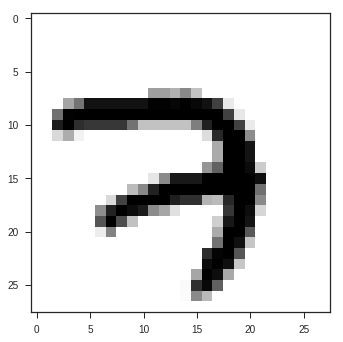

In [60]:
with sns.axes_style("ticks"):
    plt.imshow(mnist.train.images[0].reshape((28, 28)),
               cmap=plt.cm.gray_r, interpolation='nearest')
print "Label:", mnist.train.labels[0].argmax()

The linear model is very similar to before, but it now has an output of dimension 10, instead of 1.

In [61]:
reset_tf()

N_PIXELS= 28 * 28
BATCH_SIZE = 100
LEARNING_RATE = 0.5

x = tf.placeholder(tf.float32, [None, N_PIXELS], name="pixels")
y_labels = tf.placeholder(tf.float32, [None, 10], name="labels")

W = tf.Variable(tf.zeros([N_PIXELS, 10]), name="weights")
b = tf.Variable(tf.zeros([10]), name="biases")
y = tf.matmul(x, W) + b

TensorFlow has a built-in softmax entropy function for us to use.  Note that the softmax is monotonic, so we don't need to calculate the probabilities to tell which class we're predicting.  We can just find the largest component of the result of our linear model.

In [62]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_labels))
train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_labels, 1)), tf.float32))

If we run the optimizer, we can pretty easily manage about 92% accuracy.  This is not bad, given the simplicity of the model.  Random guessing would have only given us 10% accuracy.

In [63]:
reset_vars()

for i in range(1000):
    batch_x, batch_y = mnist.train.next_batch(BATCH_SIZE)
    sess.run(train,
             feed_dict={x: batch_x, y_labels: batch_y})
    if i % 100 == 0:
        print sess.run([loss, accuracy],
                       feed_dict={x: mnist.test.images, y_labels: mnist.test.labels})

[1.9663856, 0.22490001]
[0.40689775, 0.88789999]
[0.35198924, 0.89969999]
[0.31732592, 0.91360003]
[0.31923845, 0.91070002]
[0.30118349, 0.91820002]
[0.29943633, 0.91500002]
[0.29823446, 0.91259998]
[0.3005138, 0.91439998]
[0.29736775, 0.91339999]


## Exercise: Tuning hyperparameters

Adjust the learning rate and the batch size.  Can you get better performance?

## Exercise: Visualizing the weight matrix

The weight matrix $W$ contains information about how much each pixel contributes to each class.  Plot these contributions for several of the numbers.  Can you understand what the model was looking for in each case?

## Exercise: Iris classification

The [Iris data set](https://en.wikipedia.org/wiki/Iris_flower_data_set) is famous set of measurements of four features from three different species of *Iris*.  It is provided by Scikit-Learn:

In [64]:
from sklearn import datasets
iris = datasets.load_iris()
print "Features:", iris.data.shape
print "Labels:", iris.target.shape

Features: (150, 4)
Labels: (150,)


In [87]:
reset_vars()
y_cls = tf.one_hot(iris.target.tolist(), 3)
sess.run(y_cls)[0:5,:]

print iris.data[0:5,:]
print (set(iris.target.tolist()))


[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]]
set([0, 1, 2])


In [98]:
iris = datasets.load_iris()
iris_scaled = (iris.data - iris.data.mean(axis=0)) / iris.data.std(axis=0)
reset_tf()

x = tf.placeholder(tf.float32, [None, 4], name="pixels")
y_labels = tf.placeholder(tf.int32, [None], name="labels")
y_encoded = tf.one_hot(y_labels, depth=3)

W = tf.Variable(tf.zeros([4, 3]), name="weights")
b = tf.Variable(tf.zeros([3]), name="biases")
y = tf.matmul(x, W) + b

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, 
                                                              labels=y_encoded))
train = tf.train.GradientDescentOptimizer(1).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1),
                                           tf.argmax(y_encoded, 1)),
                                  tf.float32))

reset_vars()

for i in range(1000):
    sess.run(train, feed_dict={x: iris_scaled, y_labels: iris.target})
    if i % 100 == 0:
        print sess.run([loss, accuracy],
                       feed_dict={x: iris_scaled, y_labels: iris.target})

[0.54031169, 0.80000001]
[0.12240539, 0.97333336]
[0.089947417, 0.97333336]
[0.076762639, 0.97333336]
[0.069369763, 0.97333336]
[0.064550713, 0.97333336]
[0.061123211, 0.98000002]
[0.0585429, 0.98000002]
[0.056521192, 0.98000002]
[0.054889455, 0.98000002]


In [104]:
reset_tf()

x = tf.placeholder(tf.float32, [None, 4], name="pixels")
y_labels = tf.placeholder(tf.int32, [None], name="labels")
y_encoded = tf.one_hot(y_labels, depth=3)

W = tf.Variable(tf.zeros([4, 3]), name="weights")
b = tf.Variable(tf.zeros([3]), name="biases")
y = tf.matmul(x, W) + b

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_encoded))
train = tf.train.GradientDescentOptimizer(1).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_encoded, 1)), tf.float32))

reset_vars()
for i in range(1000):
    sess.run(train, feed_dict={x:iris_scaled, y_labels:iris.target})
    if i % 100==0:
        print(sess.run([loss, accuracy], feed_dict={x:iris_scaled, y_labels:iris.target}))

[0.54031169, 0.80000001]
[0.12240539, 0.97333336]
[0.089947417, 0.97333336]
[0.076762639, 0.97333336]
[0.069369763, 0.97333336]
[0.064550713, 0.97333336]
[0.061123211, 0.98000002]
[0.0585429, 0.98000002]
[0.056521192, 0.98000002]
[0.054889455, 0.98000002]


Build a classifer to descriminate between the three species based on these four features.

*Hint:* The labels are just integers specifying the class.  You will probably need to convert them to a one-hot encoded value; [`tf.one_hot()`](https://www.tensorflow.org/versions/master/api_docs/python/tf/one_hot) might be useful.

*Copyright &copy; 2017 The Data Incubator.  All rights reserved.*